In [199]:
# preparing data
from sklearn.decomposition import PCA

from models import *
from methods import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

model_name = "DAE"
DATASET = 'medical_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
REMOVE_NOISE = True
REMOVE_NOISE_THRESHOLD = 10
DENOISE = True
NOISE_FACTOR = 0.05
NOISE_FRACTION = 0.2
NORMALIZE_DATA = True
LATENT_DIM = 4
HIDDEN_DIM = 64
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-4
SIGMA = 1e0
EPOCHS = 4000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 512
INITIALIZATION = 'xavier_normal'
ALGO = 'SGD'
v = 1e-2
"""___________________________________________________________"""
# collapse
if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.95, normalize=NORMALIZE_DATA,
            filterLinearDependencies=True, filter_threshold=0.95, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)

train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
NUM_FEATURE = len(train_data[0])
print(anomalous_data.shape)
print(torch.max(anomalous_data))

Train data shape after trim:  (8005, 7)
Train data shape after normalize:  (8005, 7)
Train data shape after filter corrcoef:  (8005, 7)
removeNoise = True ---- remaining Data Shape =  (7993, 7)
torch.Size([1105, 7])
tensor(7.6634)


In [200]:
""" # train
epochs = 4000
sigma = 0
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_array = []
#model.load_state_dict(torch.load('../model/param_AE'))
model.train()
l = len(train_data)
for epoch in range(epochs):
    loss, vars = 0, 0
    permutation = np.random.permutation(l)
    for i in range(0, l, BATCH_SIZE):
        batch_idc = permutation[i:i+BATCH_SIZE]
        if DENOISE:
            batch = noisy_train_data[batch_idc,]
        else:
            batch = train_data[batch_idc,]
        noise_less_batch = train_data[batch_idc,]

        optimizer.zero_grad()
        # compute reconstructions
        outputs = model.encode(batch)
        codes = outputs
        outputs = model.decode(outputs)
        
        # compute training reconstruction loss
        var = torch.var(codes) 
        train_loss = criterion(outputs, noise_less_batch)
        loss += train_loss.item()
        vars += var
        # compute accumulated gradients
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e2)
        # perform parameter update based on current gradients
        optimizer.step()
    
    # compute the epoch training loss
    loss /= l
    vars /= l
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, code var = {}".format(epoch + 1, epochs, loss, vars))
    loss_array.append(loss)

torch.save(model.state_dict(), '../model/param_AE') """
criterion = nn.MSELoss(reduction='sum')
#model = AutoEncoder(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION,)
model = DAE(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, noise_factor=NOISE_FACTOR, noise_fraction=NOISE_FRACTION)
loss_array = train(model, ALGO, EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e3)
torch.save(model.state_dict(), '../model/param_AE')

epoch : 1/4000, loss = 5.872476
epoch : 2/4000, loss = 3.525418
epoch : 3/4000, loss = 2.678304
epoch : 4/4000, loss = 2.385843
epoch : 5/4000, loss = 2.080127
epoch : 6/4000, loss = 1.835808
epoch : 7/4000, loss = 1.636865
epoch : 8/4000, loss = 1.465533
epoch : 9/4000, loss = 1.344514
epoch : 10/4000, loss = 1.265679
epoch : 11/4000, loss = 1.195069
epoch : 12/4000, loss = 1.136819
epoch : 13/4000, loss = 1.082027
epoch : 14/4000, loss = 1.035879
epoch : 15/4000, loss = 0.996593
epoch : 16/4000, loss = 0.969021
epoch : 17/4000, loss = 0.941189
epoch : 18/4000, loss = 0.914903
epoch : 19/4000, loss = 0.895353
epoch : 20/4000, loss = 0.877997
epoch : 21/4000, loss = 0.862881
epoch : 22/4000, loss = 0.850298
epoch : 23/4000, loss = 0.828905
epoch : 24/4000, loss = 0.820658
epoch : 25/4000, loss = 0.808573
epoch : 26/4000, loss = 0.794316
epoch : 27/4000, loss = 0.783346
epoch : 28/4000, loss = 0.771463
epoch : 29/4000, loss = 0.762022
epoch : 30/4000, loss = 0.749695
epoch : 31/4000, lo

In [201]:
# evaluation
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()

input = train_data
difference = torch.square(model(input) - train_data)
lcs_array = torch.div(difference, torch.sum(difference, 1, True))
lcs_mean = torch.mean(lcs_array, 0, True)
l = len(validation_data)
permutation = np.random.permutation(l)
for i in range(0, l, BATCH_SIZE):
    batch_idc = permutation[i:i+BATCH_SIZE]
    batch = validation_data[batch_idc,]
    loss = 0
    # compute reconstructions
    outputs = model(batch)

    #print(f"input:{batch[0].data}\noutput:{outputs[0].data}")
    
    # compute the epoch validation loss
    loss = criterion(outputs, batch).item()
    loss /= len(batch)
    #i_loss = torch.sum(torch.square(batch[0]-outputs[0]))
    #print(f"Batch Average Reconstruciton Loss:{loss}")
    lcs = torch.sum((torch.square(outputs - batch) / len(batch)), 0, keepdim=False) / loss
    #print(f"Loss Contribution Score: {(lcs)}") 

print(f"Train average loss:{criterion(model(train_data), train_data) / len(train_data)}")

print(f"Validation average loss:{criterion(model(validation_data), validation_data) / len(validation_data)}")
print("Test average loss: ", criterion(model(test_data), test_data)/len(test_data))
print("Anomalous average loss: ", criterion(model(anomalous_data), anomalous_data)/len(anomalous_data))


Train average loss:0.05697719380259514
Validation average loss:0.1395241916179657
Test average loss:  tensor(0.1440, grad_fn=<DivBackward0>)
Anomalous average loss:  tensor(1.1249, grad_fn=<DivBackward0>)


In [202]:
""" # test
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()

# Collapse
if True:
    loss_test = []
    lcs_array_test = torch.tensor([[0 for _ in range(NUM_FEATURE)]])

    y_scores = []
    y_scores_lcs = []
    kl_div_test = []
    y_ground_truth = []
    # Define KL Loss
    kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=False)
    
    l = len(test_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        if False:
            batch = noisy_test_data[batch_idc,]
            Y = test_data[batch_idc,]
        else:
            batch = test_data[batch_idc,]
            Y = batch
        loss = 0
        
        # compute reconstructions
        outputs = model(batch)
        # compute the epoch test loss
        loss = criterion(outputs, Y).item()
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(0)
        loss_test.append(loss)
        #print(f"Reconstruciton Loss:{loss}")
        #lcs = torch.sum((torch.square(outputs - batch)), 0, keepdim=False) / loss
        lcs = torch.square(outputs - Y) / loss
        lcs = lcs.view(1, NUM_FEATURE)
        # KL Divergence
        this_kld = kl_loss(torch.log(lcs), lcs_mean.view(1, NUM_FEATURE)).detach().numpy()
        #print(this_kld)
        kl_div_test.append(this_kld)
        lcs_array_test = torch.cat((lcs_array_test, lcs), 0)

    lcs_array_test = lcs_array_test[1:].detach()
    lcs_mean_test = torch.mean(lcs_array_test, dim=0)
    print(lcs_mean_test)
    # Loss Contribution Score
    y_scores_lcs = torch.sum((torch.square(lcs_array_test - lcs_mean)), dim=1, keepdim=False)
    lcs_array_test = lcs_array_test.numpy()

    path = "../result_lcs"
    filename = model_name +  "_lcs_normal.csv"
    pathfile = os.path.normpath(os.path.join(path, filename))
    file_present = os.path.isfile(pathfile)
    if not file_present:
        df = pd.DataFrame(lcs_array_test) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {pathfile}")
    else:
        i = 1
        while file_present:
            print("FILE PRESENT "+ str(i))
            filename = model_name + "_lcs_normal_" + str(i) + ".csv"
            pathfile = os.path.normpath(os.path.join(path, filename))
            file_present = os.path.isfile(pathfile)
            i += 1
        df = pd.DataFrame(lcs_array_test) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {pathfile}")


    #________________________________________________________________________#

    # anomaly detection test
    loss_attack =[]
    lcs_array_attack = torch.tensor([[0 for _ in range(NUM_FEATURE)]])
    kl_div_attack = []
    l = len(anomalous_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        if False:
            batch = noisy_anomalous_data[batch_idc,]
            Y = anomalous_data[batch_idc,]
        else:
            batch = anomalous_data[batch_idc,]
            Y = batch
        loss = 0
        # compute reconstructions
        outputs = model(batch)
        # compute the epoch test loss
        loss = criterion(outputs, Y).item()
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(1)
        loss_attack.append(loss)
        #print(f"Reconstruciton Loss:{loss}")
        
        #lcs = torch.sum((torch.square(outputs - batch)), 0, keepdim=False) / loss
        lcs = torch.square(outputs - Y) / loss
        #print(f"Loss Contribution Score: {(lcs)}")
        # KL Divergence
        this_kld = kl_loss(torch.log(lcs), lcs_mean.view(1, NUM_FEATURE)).detach().numpy()
        #print(this_kld)
        kl_div_attack.append(this_kld)

        lcs_array_attack = torch.cat((lcs_array_attack, torch.reshape(lcs, (1, NUM_FEATURE))), 0)

    lcs_array_attack = lcs_array_attack[1:].detach()
    lcs_mean_attack = torch.mean(lcs_array_attack, dim=0)
    print(lcs_mean_attack)
    # Loss Contribution Score
    y_scores_lcs = torch.cat((y_scores_lcs, torch.sum((torch.square(lcs_array_attack - lcs_mean)), dim=1, keepdim=False))).detach().numpy()
    
    lcs_array_attack = lcs_array_attack.numpy()
    
    path = "../result_lcs"
    filename = model_name + "_lcs_attack.csv"
    pathfile = os.path.normpath(os.path.join(path, filename))
    file_present = os.path.isfile(pathfile) 
    if not file_present:
        df = pd.DataFrame(lcs_array_attack) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
    else:
        i = 1
        while file_present:
            print("FILE PRESENT "+ str(i))
            filename = model_name + "_lcs_attack_" + str(i) + ".csv"
            pathfile = os.path.normpath(os.path.join(path, filename))
            file_present = os.path.isfile(pathfile)
            i += 1
        df = pd.DataFrame(lcs_array_attack) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {filename}")
 """

' # test\n#model.load_state_dict(torch.load(\'../model/param_AE\'))\nmodel.eval()\n\n# Collapse\nif True:\n    loss_test = []\n    lcs_array_test = torch.tensor([[0 for _ in range(NUM_FEATURE)]])\n\n    y_scores = []\n    y_scores_lcs = []\n    kl_div_test = []\n    y_ground_truth = []\n    # Define KL Loss\n    kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=False)\n    \n    l = len(test_data)\n    permutation = np.random.permutation(l)\n    for i in range(0, l, 1):\n        batch_idc = permutation[i:i+1]\n        if False:\n            batch = noisy_test_data[batch_idc,]\n            Y = test_data[batch_idc,]\n        else:\n            batch = test_data[batch_idc,]\n            Y = batch\n        loss = 0\n        \n        # compute reconstructions\n        outputs = model(batch)\n        # compute the epoch test loss\n        loss = criterion(outputs, Y).item()\n        # append loss and class label\n        y_scores.append(loss)\n        y_ground_truth.append(0)\n      

In [203]:
# call method to test
loss_test, loss_attack, kl_div_test, kl_div_attack, y_scores_loss, y_scores_lcs, y_ground_truth, lcs_array_test, lcs_array_attack = test(model, criterion, train_data, test_data, anomalous_data)

In [204]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    model.eval()
    full_code = model.encode(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# use TSNE to show LCS 
if True:
    full_lcs = np.concatenate((lcs_array_test, lcs_array_attack), axis=0)
    #print(full_data.shape)
    tsne_lcs = tsne.fit_transform(full_lcs)

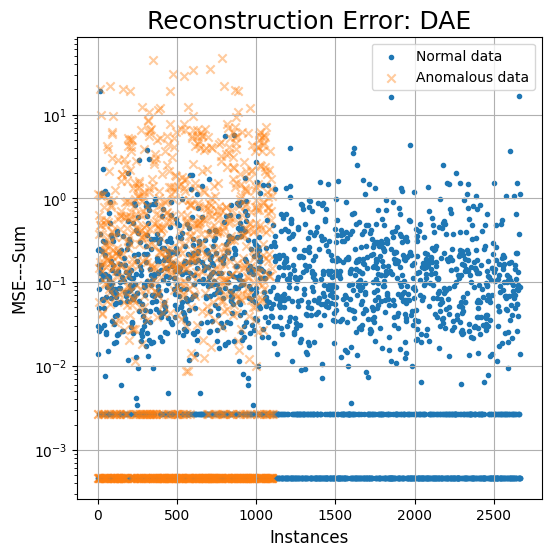

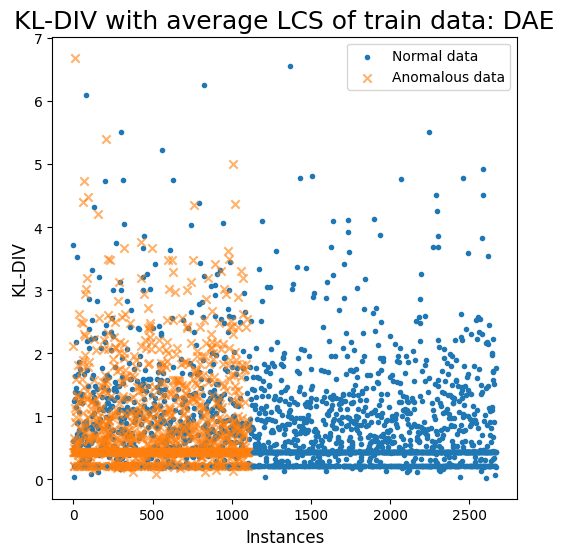

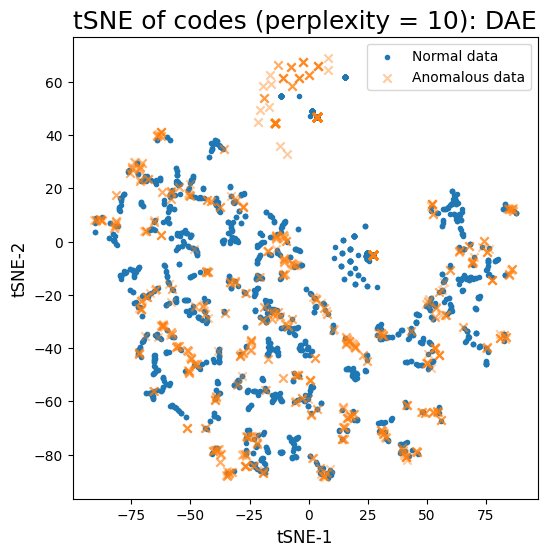

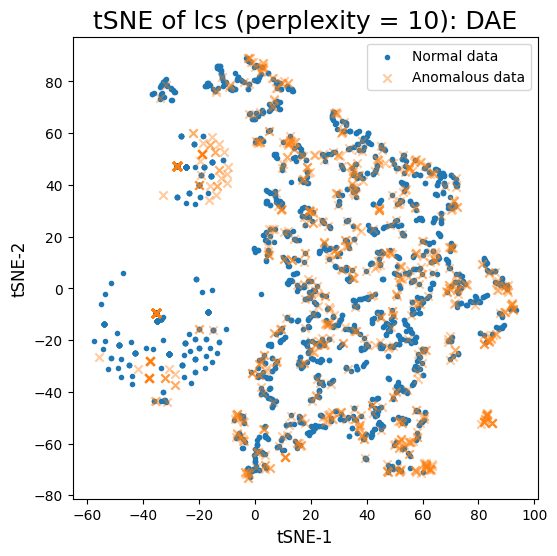

In [205]:
import matplotlib.pyplot as plt
plot1_upper_lim = 1e12
plot1_lower_lim = 0e-1
if True:
    fig = plt.figure(figsize = (6,6))

    ax = fig.add_subplot(1,1,1)

    ax.set_xlabel('Instances', fontsize = 12)
    ax.set_ylabel('MSE---Sum', fontsize = 12)
    ax.set_yscale('log')
    ax.set_title('Reconstruction Error: ' + model_name, fontsize = 18)
    ax.grid()
    ax.scatter(np.arange(len(loss_test)), loss_test, marker=".").set_label('Normal data')
    ax.scatter(np.arange(len(loss_attack)), loss_attack, marker="x", alpha=0.4).set_label('Anomalous data')
    #ax.set_ylim(plot1_lower_lim, plot1_upper_lim)
    ax.legend()

    fig2 = plt.figure(figsize = (6,6))
    
    ax2 = fig2.add_subplot(1,1,1)
    ax2.scatter(np.arange(len(kl_div_test)), kl_div_test, marker=".").set_label('Normal data')
    ax2.scatter(np.arange(len(kl_div_attack)), kl_div_attack, marker="x", alpha=0.6).set_label('Anomalous data')
    ax2.set_title('KL-DIV with average LCS of train data: ' + model_name, fontsize = 18)
    ax2.set_xlabel('Instances', fontsize = 12)
    ax2.set_ylabel('KL-DIV', fontsize = 12)
    #ax2.set_ylim(0, 2e-1)
    ax2.legend()

    # Plot the result of our TSNE with the label color coded
    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()

    # Plot the result of TSNE
    fig4 = plt.figure(figsize = (6,6))
    ax4 = fig4.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax4.scatter(tsne_lcs[:l1,0], tsne_lcs[:l1,1], 
    #np.arange(l1), 
    marker=".").set_label('Normal data')
    ax4.scatter(tsne_lcs[l1:,0], tsne_lcs[l1:,1], 
    #np.arange(l2), 
    marker="x", alpha=0.4).set_label('Anomalous data')
    ax4.set_title(('tSNE of lcs (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax4.set_xlabel('tSNE-1', fontsize = 12)
    ax4.set_ylabel('tSNE-2', fontsize = 12)
    ax4.legend()

<Figure size 500x500 with 0 Axes>

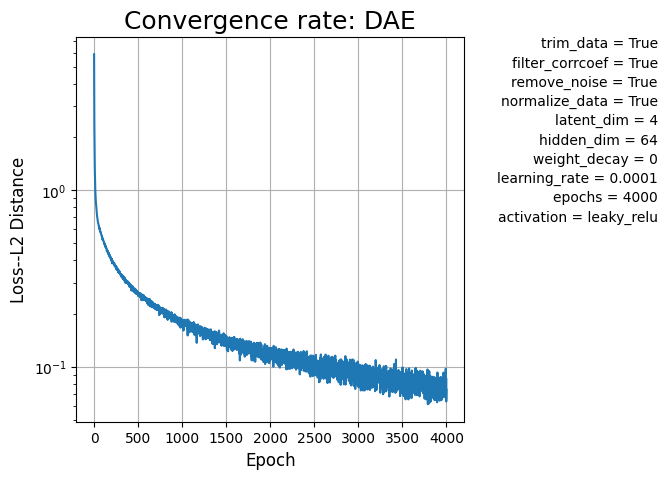

In [206]:
# convergence
def visualize_convergence(loss_array,  model_name:str, save:bool=False, **kwargs):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Epoch', fontsize = 12)
    ax.set_ylabel('Loss--L2 Distance', fontsize = 12)
    ax.set_yscale('log')
    ax.set_title('Convergence rate: ' + model_name, fontsize = 18)
    ax.grid()
    ax.plot(loss_array)
    # annotate graph
    x, y, i = 1.5, 1, 1
    for key, value in kwargs.items():
        ax.text(x, y, str(key) + " = " + str(value), ha='right', va='top', transform = ax.transAxes)
        y -= 0.05
    # save graph
    if save:
        path = "../graphs/Convergence"
        filename = model_name
        pathfile = os.path.normpath(os.path.join(path, filename))
        if not os.path.exists(path):
            os.makedirs(path)
        while os.path.isfile(pathfile + '.png'):
            pathfile = os.path.normpath(os.path.join(path, filename + str(i)))
            i += 1
        fig.savefig(pathfile)
    return ax

fig = plt.figure(figsize = (5, 5))
parameters = {"trim_data": TRIM_DATA, "filter_corrcoef": FILTER_CORRCOEF, "remove_noise": REMOVE_NOISE,
"normalize_data": NORMALIZE_DATA,
"latent_dim": LATENT_DIM,
"hidden_dim": HIDDEN_DIM,
"weight_decay": WEIGHT_DECAY,
"learning_rate": LEARNING_RATE,
"epochs": EPOCHS,
"activation": ACTIVATION}
ax = visualize_convergence(loss_array, model_name, save=False, **parameters)

ValueError: Found input variables with inconsistent numbers of samples: [3774, 4715]

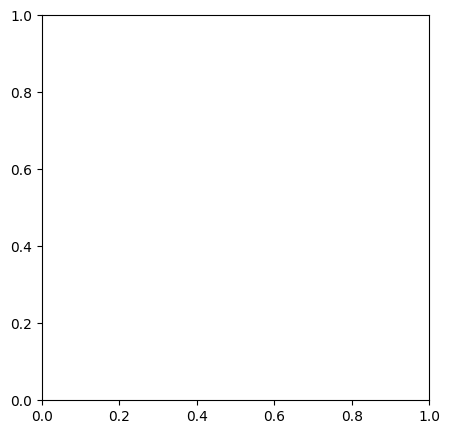

In [207]:
# ROC & AUC
from sklearn import metrics

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 

fpr_MSE, tpr_MSE, _ = metrics.roc_curve(y_ground_truth,  y_scores)
auc_MSE = metrics.roc_auc_score(y_ground_truth,  y_scores)
fpr_LCS, tpr_LCS, _ = metrics.roc_curve(y_ground_truth,  y_scores_lcs)
auc_LCS = metrics.roc_auc_score(y_ground_truth,  y_scores_lcs)

y_scores_kl = kl_div_test + kl_div_attack
fpr_KL, tpr_KL, _ = metrics.roc_curve(y_ground_truth,  y_scores_kl)
auc_KL = metrics.roc_auc_score(y_ground_truth,  y_scores_kl)


ax.set_title(model_name + '(normalized data)\n ROC Curve and AUC', fontsize = 18)
ax.plot(fpr_MSE,tpr_MSE, label="MSE auc="+str(auc_MSE))
ax.plot(fpr_LCS,tpr_LCS, label="LCS auc="+str(auc_LCS))
ax.plot(fpr_KL,tpr_KL, label="KL auc="+str(auc_LCS))
ax.set_xlabel("False Positive Rate", fontsize=15)
ax.set_ylabel("True Positive Rate", fontsize=15)
ax.legend(loc=4)